## Simulating a movement to a defined position in space
- I used an inverse kinematics solver to find the angles of the shoulder and elbows at each point in space.
- Defined the shoulder and elbows angle limits.
- I used a minimum jerk vilocity trajectory generator to generate smooth trajectory betweem two the points.
- And creates a motion file (.mot) that I ran with the help of the OpenSim Arm26 model.
- Right now I defined the joint angles to similar to the Arm26, I am working on a way that we wont need that in the future.

🎯 Selected target: (0.24, 0.30)
 - Shoulder: 10.4°
 - Elbow: 92.9°
✅ Motion file created: constrained_reach.mot


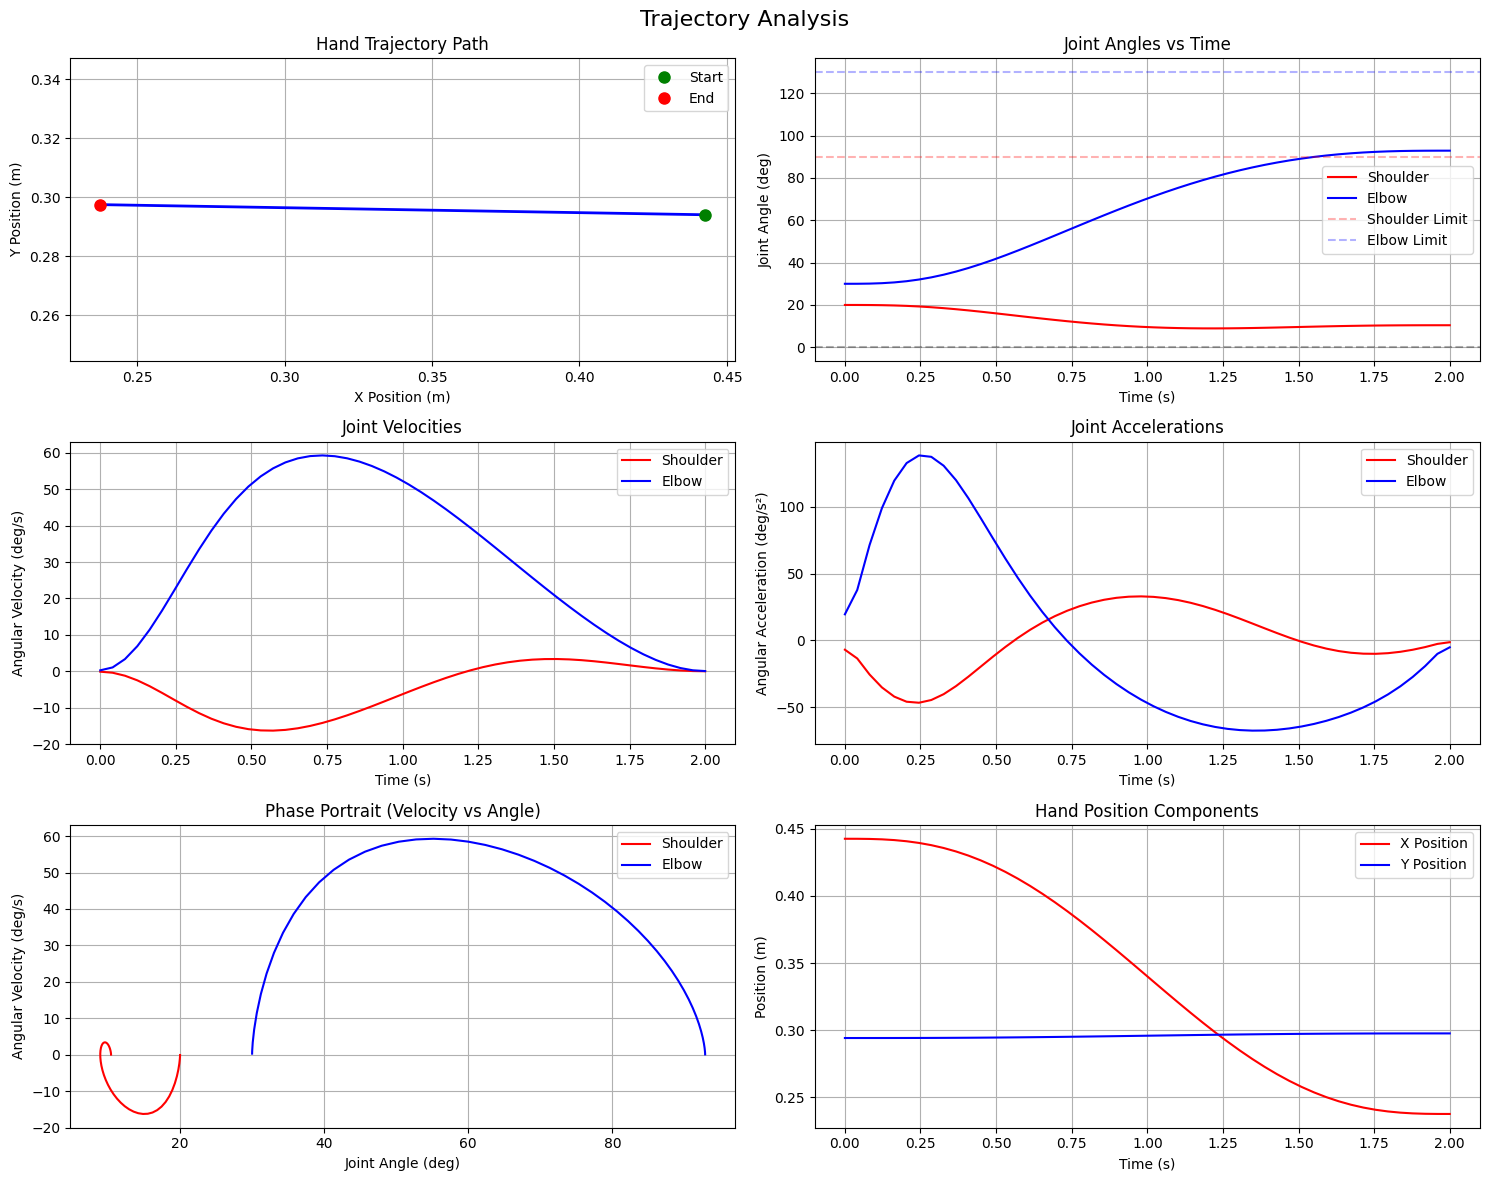


🎉 Successfully generated motion file and visualizations!
To use in OpenSim:
1. Load your model 'W:/Models/Models/Arm26/arm26.osim'
2. Load the motion file 'constrained_reach.mot'


In [ ]:
import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
from scipy.interpolate import UnivariateSpline

class Arm2D:
    """2D arm inverse kinematics solver with strict joint limits enforcement."""
    
    def __init__(self, L1, L2):
        self.L1 = L1  # Upper arm length
        self.L2 = L2  # Forearm length
        self.max_reach = L1 + L2
        self.min_reach = abs(L1 - L2)
        
        # Joint limits in radians
        self.shoulder_limits = (0, np.radians(90))
        self.elbow_limits = (0, np.radians(130))
    
    def inverse_kinematics(self, x, y):
        """Solve IK with strict joint limits enforcement."""
        r = np.sqrt(x**2 + y**2)
        
        # Check basic reachability
        if r > self.max_reach or r < self.min_reach:
            return False, (0, 0)
        
        # Calculate angles
        cos_elbow = (self.L1**2 + self.L2**2 - r**2) / (2 * self.L1 * self.L2)
        cos_elbow = np.clip(cos_elbow, -1, 1)
        elbow_angle = np.pi - np.arccos(cos_elbow)
        
        alpha = np.arctan2(y, x)
        beta = np.arccos((self.L1**2 + r**2 - self.L2**2) / (2 * self.L1 * r))
        shoulder_angle = alpha - beta
        
        # Check for elbow-down configuration if needed
        if not (self.elbow_limits[0] <= elbow_angle <= self.elbow_limits[1]):
            elbow_angle = -elbow_angle
            shoulder_angle = alpha + beta
            
        # Strictly enforce joint limits
        shoulder_angle = np.clip(shoulder_angle, *self.shoulder_limits)
        elbow_angle = np.clip(elbow_angle, *self.elbow_limits)
        
        # Verify final solution
        valid = (self.shoulder_limits[0] <= shoulder_angle <= self.shoulder_limits[1] and
                 self.elbow_limits[0] <= elbow_angle <= self.elbow_limits[1])
        
        return (valid, (shoulder_angle, elbow_angle)) if valid else (False, (0, 0))


class TrajectoryGenerator:
    """
    Generates smooth trajectories between points.
    Add another trajectory type to the code
    """
    
    @staticmethod
    def minimum_jerk_profile(t_norm):
        """Minimum jerk velocity profile: 10t³ - 15t⁴ + 6t⁵"""
        return 10 * t_norm**3 - 15 * t_norm**4 + 6 * t_norm**5
    
    def generate_trajectory(self, start_pos, end_pos, duration, num_points, trajectory_type='minimum_jerk'):
        """Generate smooth trajectory between start and end positions."""
        
        # Time vector
        t = np.linspace(0, duration, num_points)
        t_norm = t / duration  # Normalized time [0, 1]
        
        # Generate position profile based on type
        if trajectory_type == 'minimum_jerk':
            s = self.minimum_jerk_profile(t_norm)
        elif trajectory_type == 'linear':
            s = t_norm
        elif trajectory_type == 'bell_shaped':
            s = 0.5 * (1 - np.cos(np.pi * t_norm))
        else:
            s = t_norm  # Default to linear
        
        # Interpolate between start and end positions
        start_pos = np.array(start_pos)
        end_pos = np.array(end_pos)
        
        trajectory = []
        for i in range(num_points):
            pos = start_pos + s[i] * (end_pos - start_pos)
            trajectory.append(pos)
        
        return t, trajectory


class OpenSimReachingSystem:
    """Complete system for generating constrained reaching movements in OpenSim."""
    
    def __init__(self, model_path: str):
        self.model_path = model_path
        self.model = osim.Model(model_path)
        self.state = self.model.initSystem()
        self.trajectory_generator = TrajectoryGenerator()
        self._setup_arm_parameters()
    
    def _setup_arm_parameters(self):
        """Set up arm parameters and verify coordinate names."""
        # These must match your model's coordinate names exactly
        self.shoulder_coord_name = "r_shoulder_elev"  # Update to match your model
        self.elbow_coord_name = "r_elbow_flex"        # Update to match your model
        
        # Verify coordinates exist in model
        coord_set = self.model.getCoordinateSet()
        self.valid_coords = True
        try:
            coord_set.get(self.shoulder_coord_name)
            coord_set.get(self.elbow_coord_name)
        except:
            print("❌ Error: Coordinate names don't match model")
            print(f"Available coordinates:")
            for i in range(coord_set.getSize()):
                print(f"- {coord_set.get(i).getName()}")
            self.valid_coords = False
        
        # Arm geometry - adjust to match your model
        self.arm_2d = Arm2D(L1=0.3, L2=0.25)  # Upper arm and forearm lengths
    
    def set_arm_pose(self, shoulder_angle: float, elbow_angle: float):
        """Set the arm pose in the OpenSim model with strict limits."""
        if not self.valid_coords:
            return False
        
        shoulder_angle = np.clip(shoulder_angle, 0, np.radians(90))
        elbow_angle = np.clip(elbow_angle, 0, np.radians(130))
        
        try:
            # Get and set the coordinates
            shoulder = self.model.getCoordinateSet().get(self.shoulder_coord_name)
            elbow = self.model.getCoordinateSet().get(self.elbow_coord_name)
            
            shoulder.setValue(self.state, shoulder_angle)
            elbow.setValue(self.state, elbow_angle)
            
            self.model.realizePosition(self.state)
            return True
        except Exception as e:
            print(f"❌ Error setting pose: {e}")
            return False
    
    def create_motion_file(self, time_points, shoulder_angles, elbow_angles, filename):
        """Create a properly formatted OpenSim motion file."""
        if not self.valid_coords:
            return False
        
        with open(filename, 'w') as f:
            # Write header
            f.write("name reaching_movement\n")
            f.write("datacolumns 3\n")
            f.write("datarows {}\n".format(len(time_points)))
            f.write("range {} {}\n".format(time_points[0], time_points[-1]))
            f.write("endheader\n")
            
            # Write column labels
            f.write("time\t{}\t{}\n".format(
                self.shoulder_coord_name,
                self.elbow_coord_name
            ))
            
            # Write data (convert angles to degrees)
            for t, s_ang, e_ang in zip(time_points, 
                                     np.degrees(shoulder_angles),
                                     np.degrees(elbow_angles)):
                f.write("{:.6f}\t{:.6f}\t{:.6f}\n".format(t, s_ang, e_ang))
        
        print(f"✅ Motion file created: {filename}")
        return True
    
    def generate_joint_trajectories(self, start_angles, target_angles, duration, num_points):
        """
        Generate smooth joint angle trajectories using the TrajectoryGenerator.
        Returns (time_points, shoulder_angles, elbow_angles)
        """
        # Convert angles to Cartesian space for trajectory generation
        L1 = self.arm_2d.L1
        L2 = self.arm_2d.L2
        
        # Calculate start and end positions
        start_pos = (
            L1 * np.cos(start_angles[0]) + L2 * np.cos(start_angles[0] + start_angles[1]),
            L1 * np.sin(start_angles[0]) + L2 * np.sin(start_angles[0] + start_angles[1])
        )
        target_pos = (
            L1 * np.cos(target_angles[0]) + L2 * np.cos(target_angles[0] + target_angles[1]),
            L1 * np.sin(target_angles[0]) + L2 * np.sin(target_angles[0] + target_angles[1])
        )
        
        # Generate Cartesian trajectory
        time_points, cartesian_traj = self.trajectory_generator.generate_trajectory(
            start_pos, target_pos, duration, num_points, 'minimum_jerk'
        )
        
        # Convert back to joint angles through IK
        shoulder_angles = []
        elbow_angles = []
        positions = []
        
        for x, y in cartesian_traj:
            success, angles = self.arm_2d.inverse_kinematics(x, y)
            if success:
                shoulder_angles.append(angles[0])
                elbow_angles.append(angles[1])
                positions.append([x, y])
            else:
                # Use previous valid angles if IK fails
                if shoulder_angles:
                    shoulder_angles.append(shoulder_angles[-1])
                    elbow_angles.append(elbow_angles[-1])
                    positions.append(positions[-1])
                else:
                    shoulder_angles.append(start_angles[0])
                    elbow_angles.append(start_angles[1])
                    positions.append(start_pos)
        
        return (np.array(time_points), 
                np.array(shoulder_angles), 
                np.array(elbow_angles), 
                np.array(positions))
    
    def plot_trajectory_analysis(self, time_points, positions, shoulder_angles, elbow_angles):
        """Generate comprehensive trajectory analysis plots."""
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        fig.suptitle('Trajectory Analysis', fontsize=16)
        
        # Convert angles to degrees for plotting
        shoulder_deg = np.degrees(shoulder_angles)
        elbow_deg = np.degrees(elbow_angles)
        
        # Calculate derivatives for smoothness analysis
        shoulder_vel = np.gradient(shoulder_angles, time_points)
        elbow_vel = np.gradient(elbow_angles, time_points)
        shoulder_acc = np.gradient(shoulder_vel, time_points)
        elbow_acc = np.gradient(elbow_vel, time_points)
        
        # 1. Trajectory Path
        ax = axes[0, 0]
        ax.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2)
        ax.plot(positions[0, 0], positions[0, 1], 'go', markersize=8, label='Start')
        ax.plot(positions[-1, 0], positions[-1, 1], 'ro', markersize=8, label='End')
        ax.set_xlabel('X Position (m)')
        ax.set_ylabel('Y Position (m)')
        ax.set_title('Hand Trajectory Path')
        ax.grid(True)
        ax.legend()
        ax.axis('equal')
        
        # 2. Joint Angles vs Time
        ax = axes[0, 1]
        ax.plot(time_points, shoulder_deg, 'r-', label='Shoulder')
        ax.plot(time_points, elbow_deg, 'b-', label='Elbow')
        ax.axhline(0, color='k', linestyle='--', alpha=0.3)
        ax.axhline(90, color='r', linestyle='--', alpha=0.3, label='Shoulder Limit')
        ax.axhline(130, color='b', linestyle='--', alpha=0.3, label='Elbow Limit')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Joint Angle (deg)')
        ax.set_title('Joint Angles vs Time')
        ax.grid(True)
        ax.legend()
        
        # 3. Joint Velocities
        ax = axes[1, 0]
        ax.plot(time_points, np.degrees(shoulder_vel), 'r-', label='Shoulder')
        ax.plot(time_points, np.degrees(elbow_vel), 'b-', label='Elbow')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Angular Velocity (deg/s)')
        ax.set_title('Joint Velocities')
        ax.grid(True)
        ax.legend()
        
        # 4. Joint Accelerations
        ax = axes[1, 1]
        ax.plot(time_points, np.degrees(shoulder_acc), 'r-', label='Shoulder')
        ax.plot(time_points, np.degrees(elbow_acc), 'b-', label='Elbow')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Angular Acceleration (deg/s²)')
        ax.set_title('Joint Accelerations')
        ax.grid(True)
        ax.legend()
        
        # 5. Phase Portrait (Velocity vs Angle)
        ax = axes[2, 0]
        ax.plot(shoulder_deg, np.degrees(shoulder_vel), 'r-', label='Shoulder')
        ax.plot(elbow_deg, np.degrees(elbow_vel), 'b-', label='Elbow')
        ax.set_xlabel('Joint Angle (deg)')
        ax.set_ylabel('Angular Velocity (deg/s)')
        ax.set_title('Phase Portrait (Velocity vs Angle)')
        ax.grid(True)
        ax.legend()
        
        # 6. Position Components vs Time
        ax = axes[2, 1]
        ax.plot(time_points, positions[:, 0], 'r-', label='X Position')
        ax.plot(time_points, positions[:, 1], 'b-', label='Y Position')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Position (m)')
        ax.set_title('Hand Position Components')
        ax.grid(True)
        ax.legend()
        
        plt.tight_layout()
        plt.show()
    
    def create_arm_animation(self, time_points, positions, shoulder_angles, elbow_angles):
        """Create an animation of the arm movement."""
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Set up plot limits
        max_reach = self.arm_2d.L1 + self.arm_2d.L2
        ax.set_xlim(-0.1, max_reach + 0.1)
        ax.set_ylim(-0.1, max_reach + 0.1)
        ax.set_xlabel('X Position (m)')
        ax.set_ylabel('Y Position (m)')
        ax.set_title('Arm Movement Animation')
        ax.grid(True)
        
        # Initialize arm segments
        arm_line, = ax.plot([], [], 'b-', linewidth=4)
        shoulder_marker, = ax.plot([], [], 'ro', markersize=10)
        elbow_marker, = ax.plot([], [], 'go', markersize=8)
        hand_marker, = ax.plot([], [], 'mo', markersize=8)
        trajectory_line, = ax.plot([], [], 'r--', alpha=0.5)
        
        def animate(i):
            """Update animation for frame i."""
            # Calculate arm segment positions
            L1 = self.arm_2d.L1
            L2 = self.arm_2d.L2
            shoulder_ang = shoulder_angles[i]
            elbow_ang = elbow_angles[i]
            
            shoulder_pos = np.array([0, 0])
            elbow_pos = shoulder_pos + L1 * np.array([np.cos(shoulder_ang), np.sin(shoulder_ang)])
            hand_pos = elbow_pos + L2 * np.array([np.cos(shoulder_ang + elbow_ang), 
                                                np.sin(shoulder_ang + elbow_ang)])
            
            # Update arm visualization
            arm_line.set_data([shoulder_pos[0], elbow_pos[0], hand_pos[0]],
                            [shoulder_pos[1], elbow_pos[1], hand_pos[1]])
            shoulder_marker.set_data([shoulder_pos[0]], [shoulder_pos[1]])
            elbow_marker.set_data([elbow_pos[0]], [elbow_pos[1]])
            hand_marker.set_data([hand_pos[0]], [hand_pos[1]])
            
            # Update trajectory line
            trajectory_line.set_data(positions[:i+1, 0], positions[:i+1, 1])
            
            return arm_line, shoulder_marker, elbow_marker, hand_marker, trajectory_line
        
        # Create animation
        anim = FuncAnimation(fig, animate, frames=len(time_points), 
                           interval=50, blit=True, repeat=True)
        
        plt.close()
        return anim


def generate_valid_reaching_movement(model_path, output_file):
    """Generate a reaching movement with comprehensive analysis."""
    system = OpenSimReachingSystem(model_path)
    
    if not system.valid_coords:
        return False
    
    # Generate a reachable target
    while True:
        angle = np.random.uniform(0, 2*np.pi)
        distance = np.random.uniform(0.2, 0.8)  # Conservative reach distance
        target = (distance * np.cos(angle), distance * np.sin(angle))
        
        success, (shoulder_ang, elbow_ang) = system.arm_2d.inverse_kinematics(*target)
        if success:
            print(f"🎯 Selected target: ({target[0]:.2f}, {target[1]:.2f})")
            print(f" - Shoulder: {np.degrees(shoulder_ang):.1f}°")
            print(f" - Elbow: {np.degrees(elbow_ang):.1f}°")
            break
    
    # Generate smooth trajectory using the TrajectoryGenerator
    duration = 2.0
    num_points = 50
    
    # Start from slightly flexed position
    start_shoulder = np.radians(20)
    start_elbow = np.radians(30)
    
    # Generate joint trajectories
    time_points, shoulder_angles, elbow_angles, positions = system.generate_joint_trajectories(
        start_angles=(start_shoulder, start_elbow),
        target_angles=(shoulder_ang, elbow_ang),
        duration=duration,
        num_points=num_points
    )
    
    # Create motion file
    system.create_motion_file(time_points, shoulder_angles, elbow_angles, output_file)
    
    # Generate analysis plots
    system.plot_trajectory_analysis(time_points, positions, shoulder_angles, elbow_angles)
    
    # Create and display animation
    anim = system.create_arm_animation(time_points, positions, shoulder_angles, elbow_angles)
    plt.show()
    
    return True


if __name__ == "__main__":
    model_path = "W:/Models/Models/Arm26/arm26.osim"  # Replace with your actual model path
    output_file = "constrained_reach.mot"
    
    if generate_valid_reaching_movement(model_path, output_file):
        print("\n🎉 Successfully generated motion file and visualizations!")
        print("To use in OpenSim:")
        print(f"1. Load your model '{model_path}'")
        print(f"2. Load the motion file '{output_file}'")
    else:
        print("\n❌ Failed to generate valid motion file")

## to do
- [v] I have reached for the arm to move a little bit and not just twitch. But it is a small movement and it goes backward rather than forward i need to fix that
- [v] The shoulder angle should be on a 90 dergree to do a reaching movement 
- [v] The shoulder angle should be rotated to do a reaching movemnent
- [] what would be a function of the nearst vlaid positions be helpfull for the ai of vs code suggested it, have to check
- [v] Now, it is kinda hard coded that the shoulder_elev and elbow angles are 90 and 0->130, in Arm26 model, I should change that it should calculate the angle random positions in space
- [] I have to change the model to a more comprehensive model like a full body model to get more angles so I can do the reaching movemnent correclty 
- [] The joint angles names are: arm_flex_r for the shoulder, arm_rot_r, arm_add_r (shoulder), elbow_flex_r, pro_sup_r for the forearm rotation.
- [] Turn the kinematics to dynamics with the muscles